In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def run_bls(time, flux, 
            bls_params: dict = {'min_per':0.5, 'max_per':15, 
                                'minimum_n_transit':2, 
                                'freq_factor':1,
                                'durations':[0.05, 0.06666666666666668, 
                                             0.08333333333333334, 0.1,
                                             0.11666666666666668, 
                                             0.13333333333333336,
                                             0.15000000000000002, 
                                             0.16666666666666669, 
                                             0.18333333333333335, 0.2], 
                                'objective':'snr'}, 
            compute_stats: bool = True): 

    '''
    args: 
        stitched_lc: list of stitched light curve arrays [time, flux]
        bls_params: params for bls execution. see documentation
        compute_stats: compute statistics on best period/duration combination? default False
    returns: 
        results: the BLS results array 
        bls_model: the BLS model  
        in_transit_mask: mask for the in_transit points. to get not in transit, do ~in_transit_mask
        stats: if compute_stats==True, then the stats on the best period/duration/t0 are returned
    '''

    from astropy.timeseries import BoxLeastSquares
    import numpy as np

    durations = np.array(bls_params['durations'])
    bls_model = BoxLeastSquares(t=time, y=flux)
    results = bls_model.autopower(durations, frequency_factor=bls_params['freq_factor'], 
                            minimum_period=bls_params['min_per'], 
                            maximum_period=bls_params['max_per'],
                            objective=bls_params['objective'])

    index = np.argmax(results.power)
    period = results.period[index]
    t0 = results.transit_time[index]
    duration = results.duration[index]
    in_transit = bls_model.transit_mask(time, period, 2*duration, t0)
    if compute_stats: 
        stats = bls_model.compute_stats(period, duration, t0)
        return results, bls_model, in_transit, stats

    else: 
        return results, bls_model, in_transit 

In [ ]:
data = pd.read_csv('TIC_171773770.csv')
clean_time, detrend_flux = (np.array(data[col].dropna()) for col in ['cleaned_time', 'detrended_flux'])
trend_time, trend_flux, raw_time, raw_flux = (np.array(data[col].dropna()) for col in ['trend_time','trend_flux','raw_time','raw_flux'])

In [ ]:
results, bls_model, in_transit, stats = run_bls(clean_time, detrend_flux)

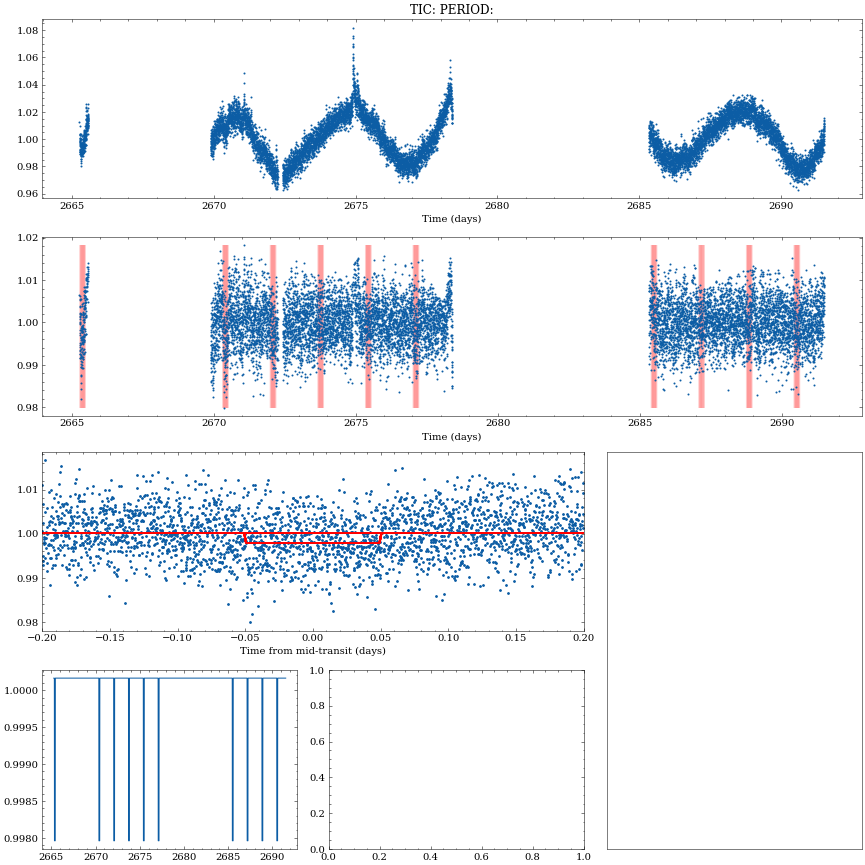

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

plt.style.use('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/code/misc/stolen_science.mplstyle?token=GHSAT0AAAAAABP54PQO2X2VXMNS256IWOBOYRNCFBA')
fig = plt.figure(constrained_layout=True, figsize=(12,12))

gs = GridSpec(4, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])
ax3 = fig.add_subplot(gs[2, :-1])
ax4 = fig.add_subplot(gs[-1, 0])
ax5 = fig.add_subplot(gs[-1, -2])
ax6 = fig.add_subplot(gs[2:, -1])

# raw and trend light curve
ax1.scatter(raw_time, raw_flux, s=1)
ax1.set(title='TIC: PERIOD:')

# detrend light curve
ax2.scatter(clean_time, detrend_flux, s=1)
index = np.argmax(results.power)
period = results.period[index]
t0 = results.transit_time[index]
duration = results.duration[index]

x = (clean_time - t0 + 0.5*period) % period - 0.5*period
m = np.abs(x) < 0.2
f = bls_model.model(x + t0, period, duration, t0)

ax2.vlines(clean_time[in_transit], min(detrend_flux), max(detrend_flux), color='red', lw=0.05,alpha=0.4, zorder=0)

for ax in [ax1, ax2]: 
    ax.set(xlabel='Time (days)')

# phase folded


ax3.scatter(x[m],detrend_flux[m], s=3)


ax3.plot(x, f, color='red')
ax3.set(xlim=(-0.2, 0.2), xlabel='Time from mid-transit (days)')

# even transits 

ax4.plot(clean_time, f)

#ax6.axis('off')
ax6.tick_params(labelbottom=False, labelleft=False, axis='both', which='both', length=0)

plt.show()

In [ ]:
set_f = list(set(f))

begin_indices = []
last_indices = []

for i in range(1, len(f)-1): 
    if f[i]==set_f[0] and f[i+1]==set_f[1]: 
        last_indices.append(i)
    elif f[i]==set_f[1] and f[i+1]==set_f[0]: 
        begin_indices.append(i+1)

for i, j in zip(begin_indices, last_indices): 
    print(i,j)

43 114
529 600
1726 1797
2801 2871
3963 4034
5169 5240
6168 6239
7369 7437
8554 8625
9760 9831


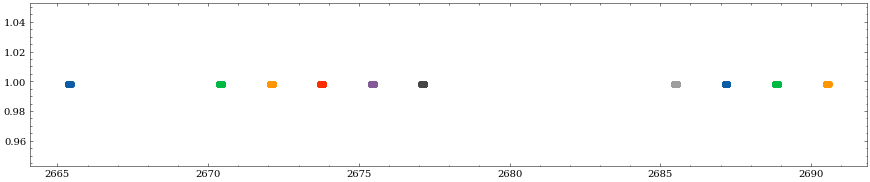

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,3))

inclusive_ranges = []

for low, high in zip(begin_indices, last_indices): 
    ax.scatter(clean_time[low:high+1], f[low:high+1])
    inclusive_ranges.append((low, high+1))

In [ ]:
inclusive_ranges = np.array(inclusive_ranges)

odd_inclusive_ranges = inclusive_ranges[range(0,len(inclusive_ranges), 2)]
even_inclusive_ranges = inclusive_ranges[range(1,len(inclusive_ranges), 2)]

print(inclusive_ranges)
print(odd_inclusive_ranges)
print(even_inclusive_ranges)

[[  43  115]
 [ 529  601]
 [1726 1798]
 [2801 2872]
 [3963 4035]
 [5169 5241]
 [6168 6240]
 [7369 7438]
 [8554 8626]
 [9760 9832]]
[[  43  115]
 [1726 1798]
 [3963 4035]
 [6168 6240]
 [8554 8626]]
[[ 529  601]
 [2801 2872]
 [5169 5241]
 [7369 7438]
 [9760 9832]]


In [ ]:
odd_transits_time = np.array([])
odd_transits_flux = np.array([])

for range in odd_inclusive_ranges: 
    low = range[0]
    high = range[1]
    odd_transits_time = np.concatenate((odd_transits_time, clean_time[low:high]))
    odd_transits_flux = np.concatenate((odd_transits_flux, detrend_flux[low:high]))

even_transits_time = np.array([])
even_transits_flux = np.array([])

for range in even_inclusive_ranges: 
    low = range[0]
    high = range[1]
    even_transits_time = np.concatenate((even_transits_time, clean_time[low:high]))
    even_transits_flux = np.concatenate((even_transits_flux, detrend_flux[low:high]))

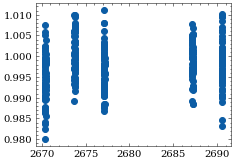

In [ ]:
plt.scatter(even_transits_time, even_transits_flux)

In [ ]:
even_x = (even_transits_time - t0 + 0.5*period) % period - 0.5*period
even_m = np.abs(even_x) < 0.2
even_f = bls_model.model(even_x + t0, period, duration, t0)

odd_x = (odd_transits_time - t0 + 0.5*period) % period - 0.5*period
odd_m = np.abs(odd_x) < 0.2
odd_f = bls_model.model(odd_x + t0, period, duration, t0)

0.9979604268524787


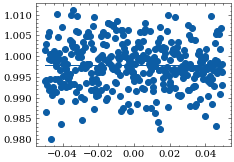

In [ ]:
plt.scatter(even_x[even_m], even_transits_flux[even_m])
plt.plot(even_x[even_m], even_f[even_m])
print(min(even_f[even_m]))

0.9979604268524787


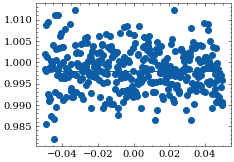

In [ ]:
plt.scatter(odd_x[odd_m], odd_transits_flux[odd_m])
plt.plot(odd_x[odd_m], odd_f[odd_m])

print(min(odd_f[odd_m]))

In [13]:
def left_right(time, flux, bls_results, bls_model, axes=None): 
    import matplotlib.pyplot as plt 
    import numpy as np

    # define f 

    index = np.argmax(bls_results.power)
    period = bls_results.period[index]
    t0 = bls_results.transit_time[index]
    duration = bls_results.duration[index]

    x = (time - t0 + 0.5*period) % period - 0.5*period
    m = np.abs(x) < 0.2
    f = bls_model.model(x + t0, period, duration, t0)    

    set_f = list(set(f))

    begin_indices = []
    last_indices = []

    for i in range(1, len(f)-1): 
        if f[i]==set_f[0] and f[i+1]==set_f[1]: 
            last_indices.append(i)
        elif f[i]==set_f[1] and f[i+1]==set_f[0]: 
            begin_indices.append(i+1)

    inclusive_ranges = []

    for low, high in zip(begin_indices, last_indices): 
        inclusive_ranges.append((low, high+1))

    inclusive_ranges = np.array(inclusive_ranges)

    odd_inclusive_ranges = inclusive_ranges[range(0,len(inclusive_ranges), 2)]
    even_inclusive_ranges = inclusive_ranges[range(1,len(inclusive_ranges), 2)]

    odd_transits_time = np.array([])
    odd_transits_flux = np.array([])

    for inclusive_range in odd_inclusive_ranges: 
        low = inclusive_range[0]
        high = inclusive_range[1]
        odd_transits_time = np.concatenate((odd_transits_time, time[low:high]))
        odd_transits_flux = np.concatenate((odd_transits_flux, flux[low:high]))

    even_transits_time = np.array([])
    even_transits_flux = np.array([])

    for inclusive_range in even_inclusive_ranges: 
        low = inclusive_range[0]
        high = inclusive_range[1]
        even_transits_time = np.concatenate((even_transits_time, time[low:high]))
        even_transits_flux = np.concatenate((even_transits_flux, flux[low:high]))

    odd_x = (odd_transits_time - t0 + 0.5*period) % period - 0.5*period
    odd_m = np.abs(odd_x) < 0.2
    odd_f = bls_model.model(odd_x + t0, period, duration, t0)

    even_x = (even_transits_time - t0 + 0.5*period) % period - 0.5*period
    even_m = np.abs(even_x) < 0.2
    even_f = bls_model.model(even_x + t0, period, duration, t0)

    if axes!=None: 
        
        axes[0].scatter(odd_x[odd_m], odd_transits_flux[odd_m])
        axes[0].plot(odd_x[odd_m], odd_f[odd_m])

        axes[1].scatter(even_x[even_m], even_transits_flux[odd_m])
        axes[1].plot(even_x[even_m], even_f[even_m])

    else: 
        fig, axes = plt.subplots(1,2, figsize=(6,3))

        axes[0].scatter(odd_x[odd_m], odd_transits_flux[odd_m])
        axes[0].plot(odd_x[odd_m], odd_f[odd_m])

        axes[1].scatter(even_x[even_m], even_transits_flux[odd_m])
        axes[1].plot(even_x[even_m], even_f[even_m])
            
        plt.show()

In [121]:
import numpy as np

def bls_validation_mosaic(tic_id:str, clean_time:np.array, detrend_flux:np.array, 
                          raw_time:np.array, raw_flux:np.array, 
                          bls_results, bls_model, in_transit, bls_stats, 
                          path:str=None, dpi:int=150): 

    '''
    arguments: 
        tic_id: tic id 
        clean_time: detrended and flare removed time array
        detrend_flux: flux values corresponding to clean_time arg
        raw_time: array of "raw" time values, i.e. not detrended and potentially with flares
        raw_flux: flux array corresponding to raw_time arg
        bls_results, bls_model, in_transit, bls_stats: the items returned by the run_bls function in pipeline_functions.py
        path: if defined, plot will be saved as the provided path. Otherwise, it will be displayed
        dpi: dpi of saved plot

    returns: 
    '''

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    from  astropy import timeseries

    plt.style.use('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/code/misc/stolen_science.mplstyle?token=GHSAT0AAAAAABP54PQO2X2VXMNS256IWOBOYRNCFBA')
    fig = plt.figure(constrained_layout=True, figsize=(12,12))

    gs = GridSpec(4, 3, figure=fig)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[2, :-1])
    ax4 = fig.add_subplot(gs[-1, 0])
    ax5 = fig.add_subplot(gs[-1, -2])
    ax6 = fig.add_subplot(gs[2:, -1])

    # raw and trend light curve
    ax1.scatter(raw_time, raw_flux, s=1)

    # detrend light curve
    ax2.scatter(clean_time, detrend_flux, s=1)
    index = np.argmax(bls_results.power)
    period = bls_results.period[index]
    t0 = bls_results.transit_time[index]
    duration = bls_results.duration[index]

    x = (clean_time - t0 + 0.5*period) % period - 0.5*period
    m = np.abs(x) < 0.2
    f = bls_model.model(x + t0, period, duration, t0)

    ax2.vlines(clean_time[in_transit], min(detrend_flux), max(detrend_flux), color='red', lw=0.05,alpha=0.4, zorder=0)

    for ax in [ax1, ax2]: 
        ax.set(xlabel='Time (days)')

    # phase folded
    ax3.scatter(x[m],detrend_flux[m], s=3, c='grey')

    folded_x, folded_flux = (x[m], flux[m])
    binned_x, binned_flux = ([], [])
    step = int(len(folded_x)/30)
    indices = list(range(0, len(folded_x), step))
    for index, i in enumerate(indices): 
        if index==len(indices)-1: 
            binned_x.append(np.mean(folded_x[i:]))
            binned_flux.append(np.mean(folded_flux[i:]))
        else: 
            binned_x.append(np.mean(folded_x[i:indices[index+1]]))
            binned_flux.append(np.mean(folded_flux[i:indices[index+1]]))

    ax3.plot(x, f, color='red', alpha=0.5)
    ax3.scatter(binned_x, binned_flux, c='orange', s=40, edgecolor='black')

    ax3.set(xlim=(-0.2, 0.2))

    for ax in [ax3, ax4, ax5]: 
        ax.set(xlabel='Time from mid-transit (days)', ylabel='Detrended Flux')

    # transit depths (odd, even)

    depth_odd = bls_stats['depth_odd']
    depth_even = bls_stats['depth_even']
    transits = [1-depth_odd[0], 1-depth_even[0]]
    errs = [depth_odd[1], depth_even[1]]
    times = [0,0.4]

    ax4.errorbar(times,
        transits,
        yerr=errs,
        fmt='o', color='red')

    ax4.plot(
        (0, 1),
        (np.mean(transits), np.mean(transits)),
        color='black', linestyle='dashed')

    ax4.plot((0, 1), (1, 1), color='black')
    ax4.set(xlabel='Time (days)', ylabel='Flux')

    # periodogram 
    ax5.plot(bls_results.period, bls_results.power)
    ax5.set(xlabel='Period (d)', ylabel='Power')

    #ax6.axis('off')
    ax6.tick_params(labelbottom=False, labelleft=False, axis='both', which='both', length=0)

    index = np.argmax(results.power)
    text_info = []
    for key_name in results.keys(): 
        result = results[key_name]
        if type(result)!=str: 
            result = str(round(result[index], 5))

        text_info.append(key_name+': '+result)

    ax6.text(x=0.1, y=0.5, s='\n'.join(str(i).replace('_','') for i in text_info), fontsize='large', va='center', transform=ax6.transAxes)

    ax1.set_title('TIC: '+str(tic_id).replace('_','')+' PERIOD: '+str(round(period, 5)), size='xx-large')

    if path==None:
        plt.show()
    else: 
        plt.savefig(path, dpi=dpi)

In [3]:
!pip install transitleastsquares

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 5.3 MB/s 
     |████████████████████████████████| 394 kB 56.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.5 MB 27.2 MB/s 
     |████████████████████████████████| 832 kB 68.7 MB/s 
     |████████████████████████████████| 48 kB 5.7 MB/s 
     |████████████████████████████████| 4.0 MB 45.1 MB/s 
  Created wheel for batman-package: filename=batman_package-2.4.8-cp37-cp37m-linux_x86_64.whl size=221064 sha256=810b6f5318fad47aae65ca3758bead6d0d28415bb36256688a693cf5e134c738
  Stored in directory: /root/.cache/pip/wheels/97/50/fb/df66c5937af30045fded1ee31db1d58510ef4e2681d5b4590c
Successfully built batman-package


In [4]:
from astropy.io import fits
from transitleastsquares import (
    transitleastsquares,
    cleaned_array,
    catalog_info,
    transit_mask
    )

url = 'https://archive.stsci.edu/hlsps/tess-data-alerts/hlsp_tess-data-alerts_tess_phot_00159951311-s03_tess_v1_lc.fits'
hdu = fits.open(url)
time = hdu[1].data['TIME']
flux = hdu[1].data['PDCSAP_FLUX']  # values with non-zero quality are nan or zero'ed
time, flux = cleaned_array(time, flux)  # remove invalid values such as nan, inf, non, negative
flux = flux / np.median(flux)

results, bls_model, in_transit, stats = run_bls(time, flux)

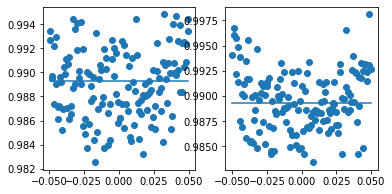

In [14]:
left_right(time, flux, results, bls_model)

In [21]:
!pip install rebin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [98]:
long_ = len(folded_x)
short = len(binned_x)

step = int(long_/30)

step

37

In [67]:
def print_factors(x):
   print("The factors of",x,"are:")
   for i in range(1, x + 1):
       if x % i == 0:
           print(i)

print_factors(len(folded_flux))

The factors of 1136 are:
1
2
4
8
16
71
142
284
568
1136


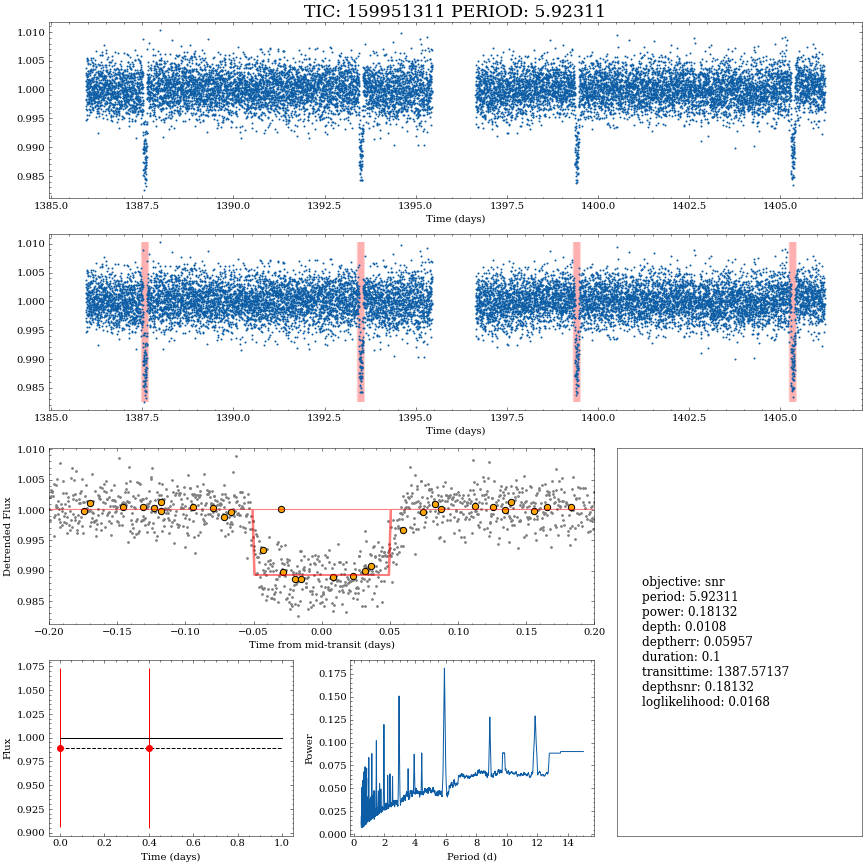

In [122]:
bls_validation_mosaic(hdu[0].header['TICID'], time, flux, time, flux, results, bls_model, in_transit, stats)

In [106]:
!pip install lightkurve
!echo nice 
import lightkurve as lk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 247 kB 6.5 MB/s 
     |████████████████████████████████| 41 kB 114 kB/s 
     |████████████████████████████████| 98 kB 7.7 MB/s 
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11375 sha256=e5af00aa30ba88cbd0c3fb4e510a97cd5931dbc65d4dc64e556ab8ad83c4d9bc
  Stored in directory: /root/.cache/pip/wheels/93/08/0c/1b9866c35c8d3f136d100dfe88036a32e0795437daca089f70
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-any.whl size=50467 sha256=1de357d493cb501895abd5725d30865565066f142dc80327ab16fc501fdbd1a4
  Stored in directory: /root/.cache/pip/wheels/38/f7/65/161985e7311dd484a23b3a5c9149995dbf11db6cede602e7ef
  Created wheel for oktopus: filename=oktopus-0.1.2-py3-none-any.whl size=12779 sha256=7bb9d251f029accc842231c483265afca7738a38746b39c01a445fe7a0771ad3
  Stored in directory: /root/.cache/pip/wheels/19/22/e3/6d22